In [1]:
import emcee
import matplotlib.pyplot as plt
import scipy.stats
from scipy import interpolate
from scipy import integrate
import numpy as np
import corner
%matplotlib inline
np.random.seed(1)

area_f = integrate.simps(f(x), x)
area_e = integrate.simps(power_law(x), x)

p1 = f(x)/area_f
p2 = power_law(x)/area_e
c = np.convolve(p1, p2, mode='same')

plt.plot(x, f(x)/area_f, '.')
plt.plot(x, power_law(x)/area_e, '.')
plt.yscale('log')
plt.xscale('log')

In [2]:
from irf import power_law
import astropy.units as u

In [23]:
crab = power_law.CrabSpectrum()
e_min = 10*u.GeV
e_max = 200*u.TeV
t_obs = 1*u.h
area = 1*u.km**2

bins=np.logspace(-2, 2, 40, base=10)
centers = bins[0:-1]+np.diff(bins)/2

N = crab.expected_events(e_min, e_max, area, t_obs)

samples = crab.draw_energy_distribution(e_min=10*u.GeV, e_max=200*u.TeV, shape=int(N))

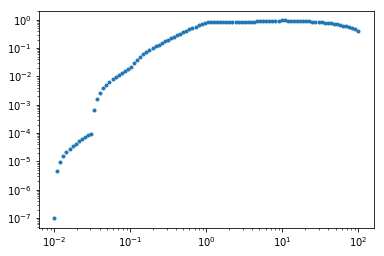

In [24]:
def acceptance_function():
    a = [0.0000001 , 0.0001, 0.02,   0.2, 0.82, 0.95, 0.4]
    e = 10**np.array([-2, -1.5 , -1  ,  -0.5, 0   , 1   , 2])
    return interpolate.interp1d(e, a)

acceptance_prob = acceptance_function()

e = np.logspace(-2, 2, 100)
plt.plot(e, acceptance_prob(e), '.')
plt.xscale('log')
plt.yscale('log')

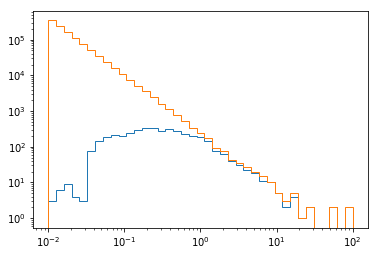

In [25]:

def apply_acceptance(samples, acceptance_prob):
    m  = np.random.uniform(0, 1, size=len(samples)) < acceptance_prob(samples)
    return samples[m]
    
triggered_samples = apply_acceptance(samples, acceptance_prob)

plt.hist(triggered_samples, bins=bins, histtype='step')
plt.hist(samples, bins=bins, histtype='step')
#plt.plot(centers, expected_events, '.')
plt.yscale('log')
plt.xscale('log')

Try and forward fold a model.

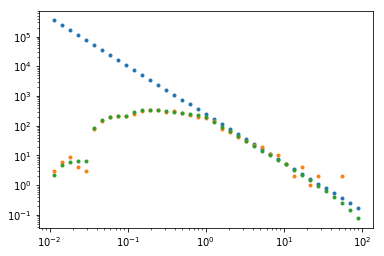

In [26]:
model = power_law.CrabSpectrum()

c_expected, edges  = model.expected_events_for_bins(e_min, e_max, area, t_obs, bins=bins*u.TeV)
c_measured, edges  = np.histogram(triggered_samples, bins=bins)

c_folded = c_expected * acceptance_prob(centers)

plt.plot(centers, c_expected, '.' )
plt.plot(centers, c_measured, '.')
plt.plot(centers, c_folded, '.')

plt.yscale('log')
plt.xscale('log')

In [14]:
def likelihood(p, data):
    A, index = p
    
    if A < 0.8 or A > 1.2:
        return -np.inf
    if index < -3 or index > -2:
        return -np.inf 
    
    c_measured, edges  = np.histogram(data, bins=bins)
    
    model = power_law.Spectrum(index=index, normalization_constant=A*1/(u.GeV * u.km**2 * u.h))
    c_expected, edges  = model.expected_events_for_bins(e_min, e_max, area, t_obs, bins=bins*u.TeV)
    c_folded = c_expected * acceptance_prob(centers)
    
    g = (c_folded - c_measured)**2 / c_folded
    g[g==np.inf] = 0
    g  = np.nan_to_num(g)
    chi_square = np.sum(g)
    return -0.5 * chi_square
 


In [15]:
index = -2.62
A = (2.83e-14 / (u.GeV * u.cm**2 * u.s)).to(1/(u.GeV * u.km**2 * u.h))
print(index)
print(A)
likelihood((A.value, index), data=triggered_samples)

-2.62
1.0188000000000001 1 / (GeV h km2)
44.91368432329668


-22.45684216164834

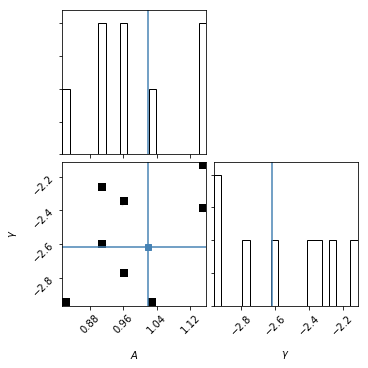

In [18]:
nwalkers = 8
ndim = 2 

p_a = np.random.uniform(0.8, 1.2, size=nwalkers) 
p_index = np.random.uniform(-2, -3, size=nwalkers) 
p0 = np.vstack([p_a, p_index]).T

_ = corner.corner(p0, labels=['$A$', '$\gamma$'], truths=[A.value, index])

In [19]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, likelihood, args=[triggered_samples], threads=4)
pos, prob, state = sampler.run_mcmc(p0, 50)
sampler.reset()
sampler.run_mcmc(pos, 200);
samples  = sampler.flatchain

110.54585991736033
370.5774450037358
3114.723988090706
555.1654658872001
4134.534379877194
1361.8948406484683
2287.1755180762348
1022.7114690947947
172.65642990264294
109.18383052121024
739.8646025853233
4228.664430693983
6583.49059273748
2793.3070372329835
57.962377685658204
286.2258259436753
898.3852577567612
3086.9215341287045
1585.069882388138
705.5243888448022
393.10635518170557
4536.416045650784
736.1563032043808
6524.081583488812
386.42925926653066
244.25653046235473
135.18915100541105
124.48073874152854
394.7619845660726
542.3472917643539
434.4051917286014
65.29965496215011
126.40907621271602
199.7425341475239
443.34656017002567
363.8237934298149
1666.288657970145
1014.866807949696
602.4620238630549
56.05761775006336
58.940814120375784
396.5828791662214
329.9634902755667
375.21634243661333
147.17759542597747
55.2197626193102
2975.218575123452
157.1874184833482
1059.2077195972138
611.2326546207763
743.860073391938
60.14805968393659
67.71526459695508
321.64020073333324
367.363151

45.606575148587694
46.81842217480449
44.261652202758015
46.97710920506395
47.91090923700914
45.50136775171532
45.37919535795461
44.05086122530859
46.9375840585514
44.11870169318278
55.70530654184195
45.73100154612254
51.648916020018994
48.87511072688393
44.11900964903373
45.300777173381235
47.96035653462393
44.22816962962992
44.18657474860644
45.814098434967946
54.47918452672886
44.329001264301255
44.28815025918613
44.222526068872845
46.71289413295803
44.074119639774956
45.50037426826921
45.10040764309829
44.137244510119515
44.086377585493274
45.246087080344935
44.03013605738726
44.64303740448826
44.262523095659745
44.02188966842729
46.979640327316794
45.329157968337384
44.0431925681673
44.40419205669377
44.62102451611295
48.27645932964304
44.03738060245858
44.56434953979374
44.044303416302235
48.587145991261984
45.92991132889918
44.354750115381314
57.35926030140726
44.3487736529819
44.15571169533574
44.9989971782736
44.72115585917853
44.22797289307001
50.34679233164342
44.506563468120

45.059198772615304
44.26377265729892
44.58694049780811
44.01439995772588
46.62756557888005
47.81007108518339
44.46218340198448
44.38812397931813
48.02532311031494
44.55312065107388
44.41822500831669
44.06744427200572
46.93460025850865
44.484555416951196
45.89049778813971
44.68426354674488
53.1576307553822
46.355101630557705
47.53435638179544
44.570926469043705
44.80847894860925
45.62995200687697
46.02990422269099
59.44760324907248
44.8881567868623
52.470654855306535
45.04629223447855
49.254688709429374
47.47931238935489
53.22589862369432
50.87251172036902
48.041916731790856
46.527133124220775
44.03485573532571
49.58512773377336
44.33447195758196
45.97391770839592
46.35080128627941
50.280885448538285
44.255127323219824
55.6869947098788
44.080844083935716
45.92829589811698
51.275230129719176
44.02746060758974
45.09927113540498
55.590030267873786
44.25842343539178
44.47264311706075
44.05870491216711
44.07711406261095
47.18123840048657
47.462746134455536
44.64201686956967
56.51741128308695

45.27150400729219
46.67612946960198
46.38252384849491
44.10203102444552
44.16938192824741
46.65611751946234
44.41513180473488
47.252420945242214
52.57718885016071
44.599212266341056
46.44325495732287
44.42662477188579
45.20277343931705
44.98771683781711
44.17847117173553
47.56224659694868
44.27484931189261
49.53482114336658
47.89605804383539
49.42243736023388
45.05851839362639
48.58571508702101
44.319728740816224
44.41982225670006
45.57483986846436
48.761477496556225
51.681361516787995
45.07143973782422
44.569369944554374
51.0659094395854
47.50193395865094
47.11677235882487
61.11508574277249
52.90146912644629
72.8448551046609
48.71705102387235
45.03931185803897
44.12508932461718
65.20867851204335
44.16044467885322
45.33353915450173
44.73246597160745
45.87425622283813
46.61572375387457
44.3065675641364
45.50821175516119
47.20239059615258
45.171788868289106
50.47678477198441
44.09321701067155
46.53658700331014
44.19190655819092
44.89948933179652
45.588475386501116
46.838147060033336
47.5

45.46296730999301
48.49442409741108
55.945080997717106
44.550325008311525
51.598686063595366
45.11369452197268
49.71043140255779
44.14350886107111
45.5423244163534
48.61012824956571
46.09890926964252
44.5379922436131
45.665628408568864
44.14439320655686
45.986122076227645
46.86196498252798
44.323506785081676
47.738002001949006
51.72843077387863
44.192954415800756
45.459539847688944
45.79892746666349
55.774302117573185
44.263615072675144
45.491470877023325
47.08853676019256
51.853242938393116
44.33299540501547
44.023719745298564
45.96574949007384
44.70002450402474
46.520249151893985
45.458271776297124
48.67038042834949
46.274084229388954
44.306446684639
44.02755383687729
44.52988084625161
45.82631504191972
45.46489571157614
49.318343974116594
47.8884508506268
52.5749503087532
44.64198994433428
44.664621453366934
45.107739449517545
44.22335335635507
50.76473777628315
44.46625801641021
50.80601390506551
46.55949490482831
44.24165595246627
44.34338311605465
44.61590632208095
44.36034863098

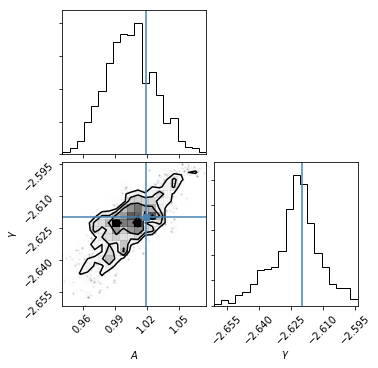

In [20]:
_ = corner.corner(samples, labels=['$A$', '$\gamma$'], truths=[A.value, index])